### Problem statement:
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph).
In this case,For the given source node (follower) and destination node(followee),we have to predict whether there is any probability of connecting between them.

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting

Data contains two columns source and destination eac edge in graph

- Data columns (total 2 columns):  
- source_node         int64  
- destination_node    int64  

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

In [52]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns 
from matplotlib import rcParams
import networkx as nx   
from matplotlib.ticker import FormatStrFormatter
plt.set_printoptions(suppress=True)

import datetime 
import time 
import math
import pickle
import os
import warnings
import pdb
import pickle

In [53]:
if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('data/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ",sum(traincsv.duplicated()))
    traincsv.to_csv('data/after_eda/train_woheader.csv',header=False,index=False)
    print("saved the graph into file")
else:
    g=nx.read_edgelist('data/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    # “create_using=nx.Digraph()” i.e. now it will create directed graph.
    print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


#### Creating the samples of training dataset of 50 rows for visualization purpose :

DiGraph with 66 nodes and 50 edges


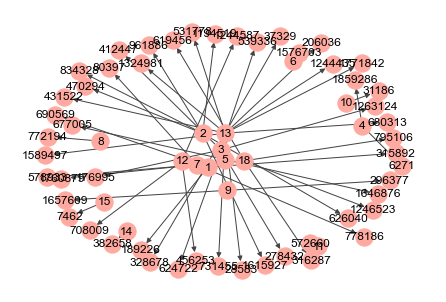

In [54]:
if not os.path.isfile('train_woheader_sample.csv'):
    pd.read_csv('data/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

pos=nx.spring_layout(subgraph)
# In the spring_layout graph it represent the node in such a manner that the inner nodes 
# are the source node and outer nodes are destination.

nx.draw(subgraph,pos,node_color='#ffaaa1',edge_color='#444444',width=1,edge_cmap=plt.cm.Greens,with_labels=True)
print(nx.info(subgraph))

## Exploratory Data Analysis

In [55]:
type(g)

networkx.classes.digraph.DiGraph

In [56]:
len(g.nodes())

1862220

In [57]:
len(g.edges())

9437519

In [58]:
print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


#### Observation:

    No. of nodes : 1862220. It means we have this number of unique peoplee data in our dataset.
    No. of edges : 9437519. The number of present edges.

### 1. Number of followers for each person

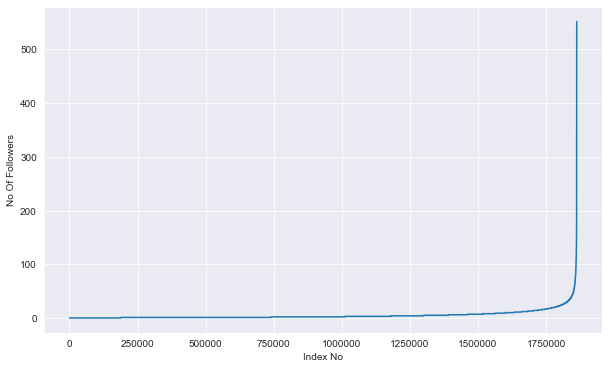

In [59]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()

sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
plt.ticklabel_format(style='plain')

plt.plot(indegree_dist)

plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

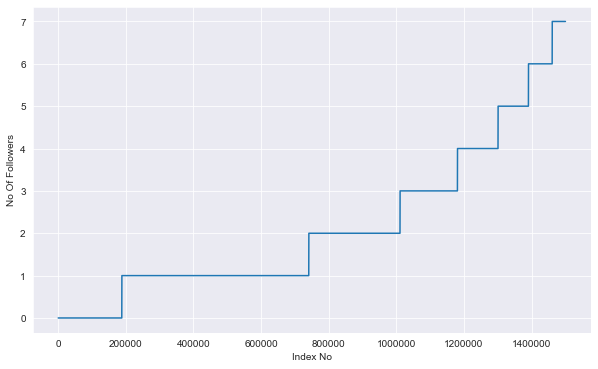

In [9]:
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.ticklabel_format(style='plain')

plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

#### Observation:

we say that we have less number of people who having more followers i.e. our dataset contains more number of people who having follower around 0-8 means those people who rarely active on social media.

In [10]:
print(np.mean(indegree_dist))
print(np.median(indegree_dist))

5.067886178861789
2.0


#### Obervation:
1. If the mean is greater than the median, then we can say that the distribution is **positively skewed.**

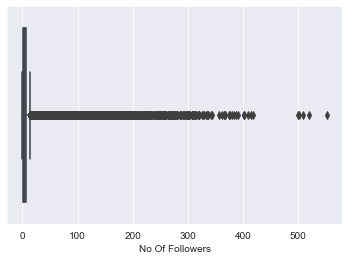

In [11]:
sns.boxplot(indegree_dist);
plt.xlabel('No Of Followers');

#### Obervation:
1. We can see that, we have lots of outliers which makes our plot **positively skewed.**

In [60]:
for i in range(0,101,10):
    print(i,'percentile value is',np.percentile(indegree_dist,i))

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 1.0
30 percentile value is 1.0
40 percentile value is 2.0
50 percentile value is 2.0
60 percentile value is 3.0
70 percentile value is 5.0
80 percentile value is 7.0
90 percentile value is 12.0
100 percentile value is 552.0


In [61]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


In [62]:
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


In [63]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#### Observation:
1. From 90 to 99 the people having less number of followers(under 40).
2. From 99.1 to 99.9 the number of follower increases dramatically(very less number of peoples).

In [64]:
pd.Series(indegree_dist).describe()

count   1862220.00000
mean          5.06789
std           9.43321
min           0.00000
25%           1.00000
50%           2.00000
75%           6.00000
max         552.00000
dtype: float64

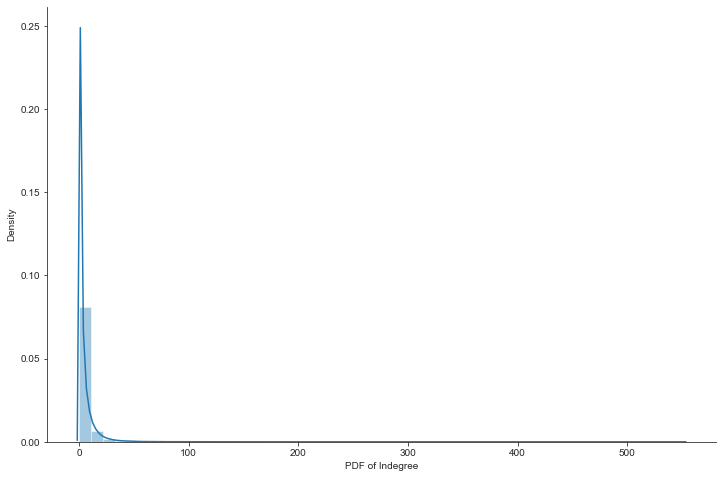

In [65]:
%matplotlib inline
sns.set_style('ticks')

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

sns.distplot(indegree_dist)
plt.xlabel('PDF of Indegree')
sns.despine()

#### There is also a possibility that the people are not following to anyone or not followed by anyone.

In [66]:
sum(np.array(indegree_dist)==0)

188043

In [67]:
sum(np.array(indegree_dist)==0)*100/len(indegree_dist)

10.097786512871734

#### No of persons having zero followers are 188043 and which is 10.098%

### 2.No of people each person is following

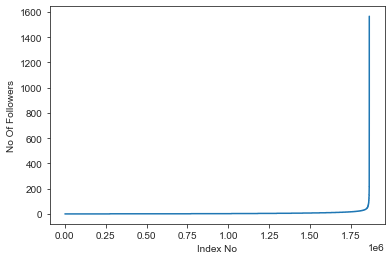

In [20]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()

plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('Number Of Followers')
plt.show()

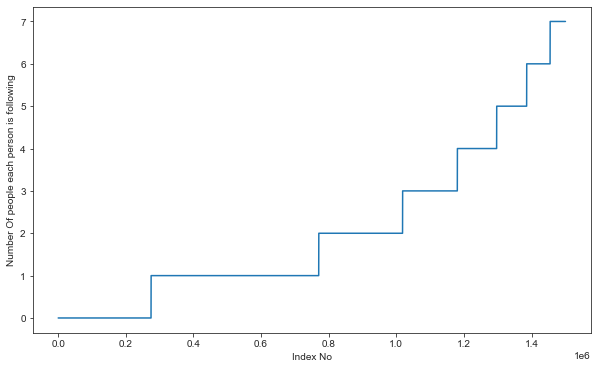

In [69]:
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('Number Of people each person is following')
plt.show()

In [22]:
for i in range(0,101,10):
    print(i,'percentile value is',np.percentile(outdegree_dist,i))

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 1.0
30 percentile value is 1.0
40 percentile value is 1.0
50 percentile value is 2.0
60 percentile value is 3.0
70 percentile value is 5.0
80 percentile value is 7.0
90 percentile value is 12.0
100 percentile value is 1566.0


In [23]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [24]:
for i in range(0,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.0 percentile value is 40.0
99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


#### Observation:
1. From 90 to 99 the people having following less number of people(under 40).
2. From 99.1 to 99.9 the number of follower increases.

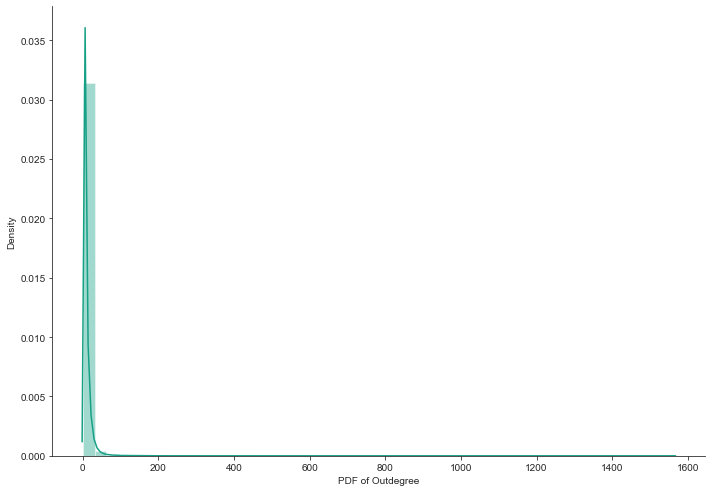

In [25]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [68]:
print('Number of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

Number of persons those are not following anyone are 274512 and % is 14.741115442858524


### 1.3 both followers + following

In [27]:
from collections import Counter

dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())

d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

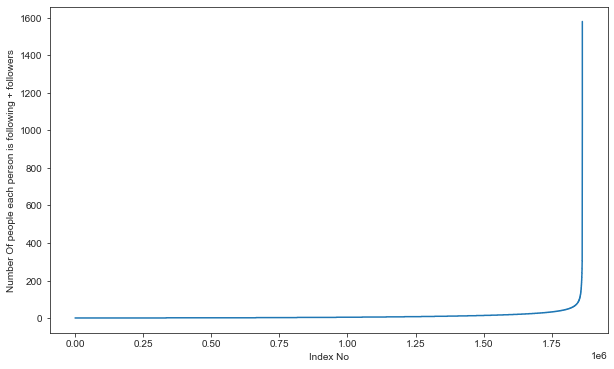

In [70]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('Number Of people each person is following + followers')
plt.show()

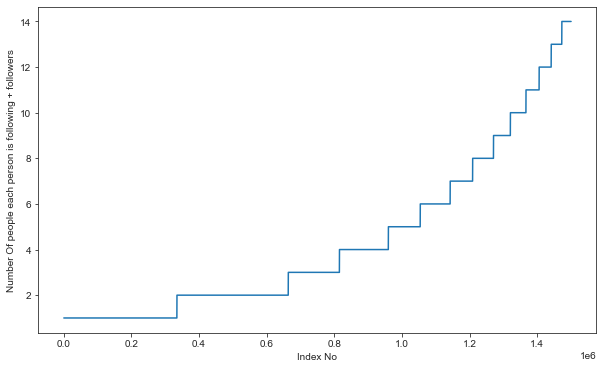

In [71]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('Number Of people each person is following + followers')
plt.show()

In [30]:
### 0-100 percentile
for i in range(0,101,10):
    print(i,'percentile value is',np.percentile(in_out_degree_sort,i))

0 percentile value is 1.0
10 percentile value is 1.0
20 percentile value is 2.0
30 percentile value is 2.0
40 percentile value is 3.0
50 percentile value is 4.0
60 percentile value is 6.0
70 percentile value is 9.0
80 percentile value is 14.0
90 percentile value is 24.0
100 percentile value is 1579.0


In [31]:
for i in range(0,11):   # 90-100 percentile
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [32]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [72]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


In [73]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [74]:
print('No of weakly connected components',len(list(nx.weakly_connected_components(g))))
count=0
for i in list(nx.weakly_connected_components(g)):
    if len(i)==2:
        count+=1
print('weakly connected components with 2 nodes',count)

No of weakly connected components 45558
weakly connected components with 2 nodes 32195


### Generating some edges which are not present in graph for supervised learning

Here,We are creating balenced data set by creating missing edge in between the source node and destination node with random.

In [76]:
%%time
###generating bad edges from given graph
import random
if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2:  # checking that if the edge is missing and source node is not equal to destination node

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.p','rb'))

Wall time: 7.93 s


In [77]:
len(missing_edges)

9437519

## 2.2 Training and Test data split:  
Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [81]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Train test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

We have splitted the data on the based on **number of the edges** not on nodes.

In [82]:
if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    # we are using only positive graph
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(round(teY_trN/len(test_nodes_pos)*100,2)))

DiGraph with 1780722 nodes and 7550015 edges
DiGraph with 1144623 nodes and 1887504 edges
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.12 %


If we have data/nodes present in the test data but not in the train data,then we call it as  Cold start problem.
here also we can see that **we have cold start problem.**

In [83]:
#final train and test data sets
if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)

In [84]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

NameError: name 'X_train' is not defined